In [8]:
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily

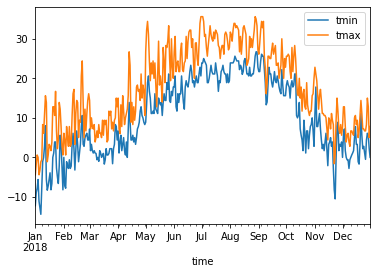

In [17]:
# Set time period
start = datetime(2018, 1, 1)
end = datetime(2018, 12, 31)

# Create Point for Vancouver, BC
vancouver = Point(49.2497, -123.1193, 70)
nyc = Point(40.730610, -73.935242)

# Get daily data for 2018
data = Daily(nyc, start, end)
data = data.fetch()

# Plot line chart including average, minimum and maximum temperature
data.plot(y=['tmin', 'tmax'])
plt.show()

In [15]:
from meteostat import Stations

stations = Stations()
stations = stations.nearby(40.730610, -73.935242)
station = stations.fetch(1)

print(station)


                            name country region   wmo  icao  latitude  \
id                                                                      
KNYC0  New York City / Yorkville      US     NY  <NA>  KNYC   40.7789   

       longitude  elevation          timezone hourly_start hourly_end  \
id                                                                      
KNYC0   -73.9692        3.0  America/New_York   1943-12-01 2023-05-31   

      daily_start  daily_end monthly_start monthly_end     distance  
id                                                                   
KNYC0  1943-12-02 2022-04-24    1944-01-01  2021-01-01  6083.922569  
